This notebook attempts to fit traditional NLP techniques - SVD, Trigrams etc. - to the economic data newspaper set to draw signal for the relevance dataset. To build robust trigram models, smoothening and discounting are used on the maximum likelihood statistics drawn to balance probability estimates for binary classification. The SVD attempts simple clustering mechanisms to find underlying similarities between article snippets.

In [217]:
import pandas as pd
import numpy as np
import scipy as sp
import nltk
import re
import os
import gc
import pickle
import json
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from umap.umap_ import UMAP

In [107]:
trainX = pickle.load(open('./data/relevance_trainX.pkl', "rb"))
trainY = pickle.load(open('./data/relevance_trainY.pkl', "rb"))
testX = pickle.load(open('./data/relevance_testX.pkl', "rb"))
testY = pickle.load(open('./data/relevance_testY.pkl', "rb"))

<h2> Supervised Learning - Trigram Model

Create two trigram models $ M_{+} $ and $ M_{-} $ such that every sentence $ S_{i} $, the probability of relevance is given by a softmax activation, namely $\frac{P_{M+}(S_{i})}{\sum P(S_{i})} $

In [108]:
#Token cleaning: Stemming, <START> and <END>, <NUM> tag
def num_tag(num):
    digits = np.array(['1','2','3','4','5','6','7','8','9','0'])
    return sum(np.vectorize(lambda s: s in num)(digits))>0
def cleaner_vocab(s):
    if s[0]=="\'" and s[-1]=="\'": s = s[1:-1]
    if "." in s and len(s)!=1: s = s.replace(".","")
    return s
def trigram_text(s):
    s = "<start> <start> "+s+" <end>"
    s = np.vectorize(lambda s: "<num>" if num_tag(s) else s)(s.split())
    return np.vectorize(lambda s: cleaner_vocab(s))(s)
trainX = trainX.apply(lambda txt: trigram_text(txt))

In [109]:
#Limit the length of individual news articles since a trigram based probability is likely
#to get smaller with more words, and approaching close to the minimum float Python can
#represent, reducing to 0
print(trainX.apply(len).value_counts(bins=10).sort_index())
trainX = trainX.apply(lambda s: s[:150])

(12.64, 48.9]      689
(48.9, 84.8]      2032
(84.8, 120.7]      803
(120.7, 156.6]     143
(156.6, 192.5]      34
(192.5, 228.4]      11
(228.4, 264.3]       4
(264.3, 300.2]       3
(300.2, 336.1]       0
(336.1, 372.0]       1
Name: text, dtype: int64


In [6]:
postrainX = trainX[trainY==1].copy().reset_index(drop=True)
negtrainX = trainX[trainY==0].copy().reset_index(drop=True)

In [7]:
#Define a Trigram Model
class LangModel():
    def __init__(self):
        self.unigram, self.bigram, self.trigram = {}, {}, {}
    
    def add_unigram(self, word3):
        self.unigram[word3] = 1 if self.unigram.get(word3, None) is None else self.unigram[word3]+1
    
    def add_bigram(self, word2, word3):
        if self.bigram.get(word2, None) is None:
            self.bigram[word2] = {}
            self.bigram[word2][word3] = 1
        elif self.bigram.get(word2, None).get(word3, None) is None:
            self.bigram[word2][word3] = 1
        else:
            self.bigram[word2][word3]+=1
    
    def add_trigram(self, word1, word2, word3):
        if self.trigram.get(word1, None) is None:
            self.trigram[word1] = {}
            self.trigram[word1][word2] = {}
            self.trigram[word1][word2][word3] = 1
        elif self.trigram[word1].get(word2, None) is None:
            self.trigram[word1][word2] = {}
            self.trigram[word1][word2][word3] = 1
        elif self.trigram[word1][word2].get(word3, None) is None:
            self.trigram[word1][word2][word3]  = 1
        else:
            self.trigram[word1][word2][word3] += 1

    def inc_count(self, word1, word2, word3):
        self.add_unigram(word3)
        self.add_bigram(word2, word3)
        self.add_trigram(word1, word2, word3)   
        
    def counts(self, arr):
        if len(arr)>3: return
        if len(arr)==1:
            return self.unigram.get(arr[0], 0)
        if len(arr)==2:
            return 0 if self.bigram.get(arr[0], None) is None else self.bigram[arr[0]].get(arr[1], 0)
        if len(arr)==3:
            if (self.trigram.get(arr[0],None) is None) or (self.trigram[arr[0]].get(arr[1],None) is None):
                return 0
            else:
                return self.trigram[arr[0]][arr[1]].get(arr[2], 0)        

In [8]:
#Creating unigram, bigram and trigram probability dictionaries
#Define word counts
posModel, negModel = LangModel(), LangModel()
for sent in postrainX:
    posModel.add_bigram("<start>", "<start>")
    for i in range(2, len(sent)):
        posModel.inc_count(sent[i-2], sent[i-1], sent[i])
for sent in negtrainX:
    posModel.add_bigram("<start>", "<start>")
    for i in range(2, len(sent)):
        negModel.inc_count(sent[i-2], sent[i-1], sent[i])

<p> Application of Linear Interpolation on Maximum Likelihood Estimates: <p>
$ P(w|u,v) = \lambda_{1} * Q_{ML}(w|u,v) + \lambda_{2} * Q_{ML}(w|v) + (1 - \lambda_{1} - \lambda_{2}) * Q_{ML}(w) $
<br\><br\>
where the  $ Q_{ML} $ refers to traditional maximum likelihood estimates (unigrams, bigrams, and trigrams), and
<br\>
$ \lambda_{1} = \dfrac {c(u,v)}{c(u,v)+\gamma} $, 
$ \lambda_{2} = (1 - \lambda_{1}) * \dfrac {c(v)}{c(v)+\gamma} $
<br\>
where $ \gamma $ is optimized by minimizing perplexity or minimizing log loss on the training set.

In [15]:
#define linear interpolation
#Use 1e-3 tolerance parameter for smoothening unigram probabilities
def probability(model, sent, gamma):
    prob = 1
    for i in range(2, len(sent)):
        lambda1, lambda2, trigramval, bigramval = 0, 0, 0, 0
        if (model.counts([sent[i-2], sent[i-1]]) + gamma)!=0:
            lambda1 = model.counts([sent[i-2], sent[i-1]]) / (model.counts([sent[i-2], sent[i-1]]) + gamma)
        if (model.counts([sent[i-1]]) + gamma)!=0:
            lambda2 = (1 - lambda1) * model.counts([sent[i-1]]) / (model.counts([sent[i-1]]) + gamma)
        if model.counts([sent[i-2], sent[i-1]])!=0:
            trigramval = model.counts([sent[i-2], sent[i-1], sent[i]]) / model.counts([sent[i-2], sent[i-1]])
        if model.counts([sent[i-1]])!=0:
            bigramval = model.counts([sent[i-1], sent[i]]) / model.counts([sent[i-1]])
        unigramval = model.counts([sent[i]]) / sum(model.unigram.values()) if model.counts([sent[i]])!=0 else 1e-3
        prob *= lambda1*trigramval + lambda2*bigramval + (1-lambda1-lambda2)*unigramval
        #Python floating point limitations do not permit smaller calculations
        #During our tests, only 1-2 sentences activate this if-condition
        if prob==0: return 1e-323
    return prob

<p>Gradient Descent for Optimal Gamma:</p>
<br\>
To optimize the value of $ \gamma $ for linear interpolation, we attempt gradient descent to minimize perplexity, which is defined as $ PX = 2^{-l} $ where $ l = \frac{1}{M} \sum log_{2}(P(S_{i})) $ with M being the vocabulary size. Above, $ P(S_{i}) = \prod P(w|u,v) $ for every trigram sequence $ (u,v,w) $ in $ S_{i} $, as defined earlier. We run gradient descent with a $ 10^{-13} $ learning rate and 150 iterations, with a gamma originally drawn from a uniform distribution.
<br\><br\>
Let $ \gamma $ be initialized. For iterations e = 1,..., 150:
<br\>
    $ \gamma = \gamma + 10^{-13} \times PX \times \frac{1}{M}\sum \frac{\frac{d}{d\gamma}(P(S_{i}))}{P(S_{i})} $
    

In [10]:
#We approximate probability gradient using first principles of differentiation
#Continue to use the tolerance level of 1e-3 as extent of change
def grad(model, sent, gamma):
    return (probability(model, sent, gamma+1e-3) - probability(model, sent, gamma))/1e-3
def descent(model, sents):
    np.random.seed(1)
    gamma = np.random.uniform()*10
    learning_rate = 1e-13
    gammatime = pd.Series(index=np.arange(150))
    for i in range(150):
        gammatime[i] = gamma
        probarr = np.vectorize(lambda s: probability(model,sents[s],gamma))(np.arange(len(sents)))
        gradarr = np.vectorize(lambda s: grad(model,sents[s],gamma))(np.arange(len(sents)))
        M = len(np.unique([word for sent in sents.values for word in sent]))
        perplex = 2**(-1/M * np.sum(np.log2(probarr)))
        gamma += learning_rate * perplex * 1/M * np.sum(gradarr/probarr)
        if i%10==0: print("Progress Update: Iteration "+str(i))
    plt.figure(figsize=(10,10))
    gammatime.plot()
    plt.show()
    return gamma

Progress Update: Iteration 0
Progress Update: Iteration 10
Progress Update: Iteration 20
Progress Update: Iteration 30
Progress Update: Iteration 40
Progress Update: Iteration 50
Progress Update: Iteration 60
Progress Update: Iteration 70
Progress Update: Iteration 80
Progress Update: Iteration 90
Progress Update: Iteration 100
Progress Update: Iteration 110
Progress Update: Iteration 120
Progress Update: Iteration 130
Progress Update: Iteration 140


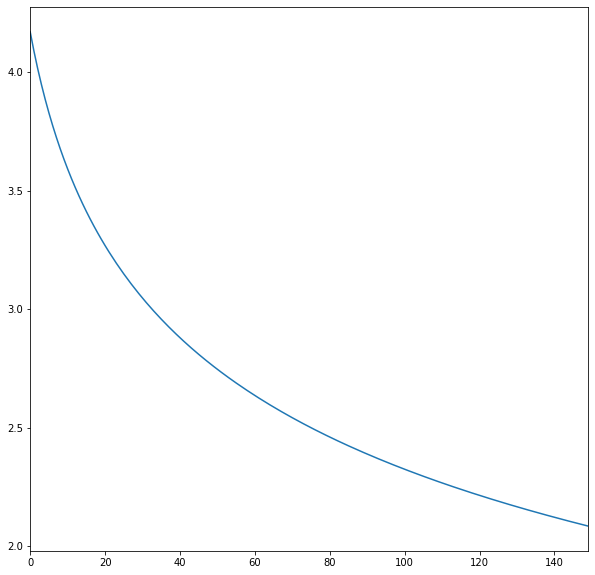

In [22]:
#choosing singular smoothing parameter through perplexity maximization with gradient descent
posgamma = descent(posModel, postrainX)

Progress Update: Iteration 0
Progress Update: Iteration 10
Progress Update: Iteration 20
Progress Update: Iteration 30
Progress Update: Iteration 40
Progress Update: Iteration 50
Progress Update: Iteration 60
Progress Update: Iteration 70
Progress Update: Iteration 80
Progress Update: Iteration 90
Progress Update: Iteration 100
Progress Update: Iteration 110
Progress Update: Iteration 120
Progress Update: Iteration 130
Progress Update: Iteration 140


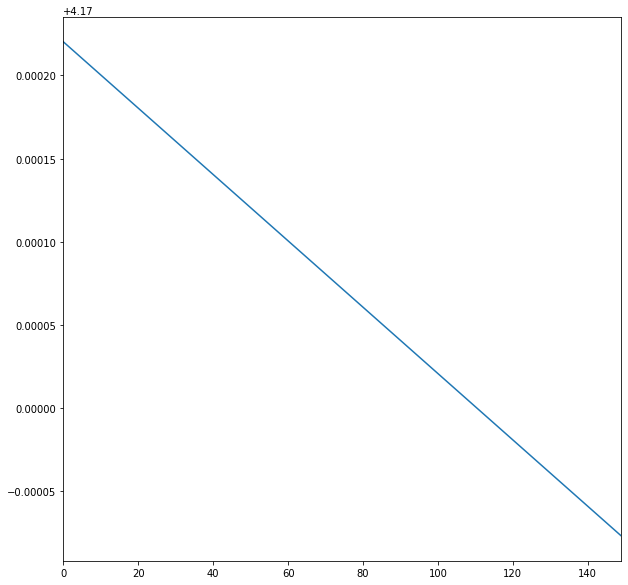

In [23]:
neggamma = descent(negModel, negtrainX)

In [110]:
testX = testX.apply(lambda txt: trigram_text(txt))
testX = testX.apply(lambda s: s[:150])

In [28]:
#Apply softmax activation to generate train and test probabilities
def predict_proba(X):
    posprob = X.apply(lambda s: probability(posModel, s, posgamma))
    negprob = X.apply(lambda s: probability(negModel, s, neggamma))
    retval = posprob/(posprob+negprob)
    return np.concatenate([(1-retval).values.reshape(-1,1), retval.values.reshape(-1,1)], axis=1)
trainYpred = predict_proba(trainX)
testYpred = predict_proba(testX)

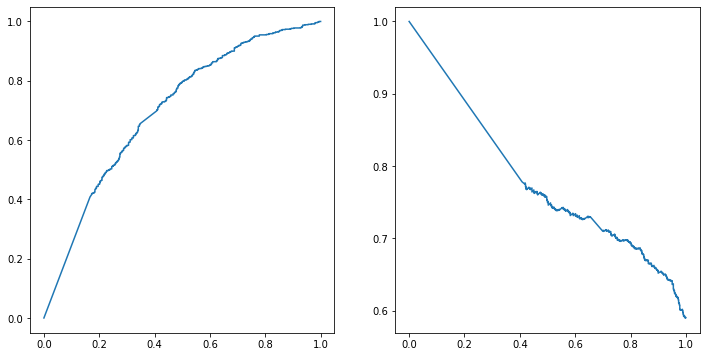

In [34]:
#AUC-ROC and Precision-Recall
tpr2, fpr2, _ = sklearn.metrics.roc_curve(testY, testYpred[:,1])
prec2, rec2, _ = sklearn.metrics.precision_recall_curve(testY, testYpred[:,1])
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tpr2, fpr2)
plt.subplot(1,2,2)
plt.plot(rec2, prec2)
plt.show()

In [52]:
#Confusion Matrix
k = sklearn.metrics.confusion_matrix(testY, np.vectorize(lambda s: 1 if s>0.5 else 0)(testYpred[:,1]))
sumv = np.vstack(np.sum(k, axis=1))
k/np.concatenate([sumv, sumv], axis=1)

array([[0.65294118, 0.34705882],
       [0.34520548, 0.65479452]])

In [54]:
print(sklearn.metrics.classification_report(testY, np.vectorize(lambda s: 1 if s>0.5 else 0)(testYpred[:,1])))

              precision    recall  f1-score   support

           0       0.57      0.65      0.61       510
           1       0.73      0.65      0.69       730

    accuracy                           0.65      1240
   macro avg       0.65      0.65      0.65      1240
weighted avg       0.66      0.65      0.66      1240



<h2> SVD Matrix Decomposition + Cosine Nearest Neighbours Approach </h2>

We attempt a new architecture where an SVD is performed on train set, the test set vectorized matrix is converted to the same space dimensionality and then cosine similarity is used to match nearest-neighbours.

In [111]:
trainX = trainX.apply(lambda s: ' '.join(s[2:-1]))
testX = testX.apply(lambda s: ' '.join(s[2:-1]))

In [117]:
vec = TfidfVectorizer(stop_words='english', max_features=5000, max_df=0.5, smooth_idf=True)
trainX = vec.fit_transform(trainX)
testX = vec.transform(testX)
%time U, S, Vh = sp.linalg.svd(trainX.todense(), full_matrices=False, compute_uv=True, overwrite_a=False)

CPU times: user 1min 4s, sys: 1.85 s, total: 1min 6s
Wall time: 17.4 s


In [151]:
#Adjust the test set to same axes
testX = np.array(testX.todense())
finaltestX = np.zeros((testX.shape[0], U.shape[1]), dtype='float')
converter = np.matmul(np.diag(1/S), Vh)
for i in range(testX.shape[0]):
    finaltestX[i,:] = np.matmul(converter, testX[i])

In [179]:
#Compile cosine distance matrix
cossim = pd.DataFrame(index=np.arange(finaltestX.shape[0]), columns=np.arange(trainX.shape[0]))
cossim = cossim.apply(lambda s: s.apply(lambda g: s.name))
cossim = cossim.apply(lambda s: s.apply(lambda g: (s.name, g)), axis=1)
cossim = cossim.applymap(lambda s: sp.spatial.distance.cosine(finaltestX[s[0]], U[s[1]]))

In [199]:
def predict(cosine, trainY):
    relpos = np.argsort(cosine)[:5]
    return (np.vectorize(lambda s: trainY[s])(relpos)).sum()/5
testYpred = cossim.apply(lambda s: predict(s, trainY), axis=1)

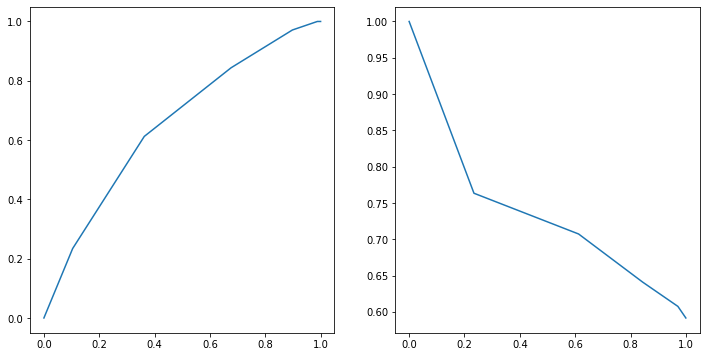

In [201]:
#AUC-ROC and Precision-Recall
tpr2, fpr2, _ = sklearn.metrics.roc_curve(testY, testYpred)
prec2, rec2, _ = sklearn.metrics.precision_recall_curve(testY, testYpred)
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(tpr2, fpr2)
plt.subplot(1,2,2)
plt.plot(rec2, prec2)
plt.show()

In [203]:
#Confusion Matrix
k = sklearn.metrics.confusion_matrix(testY, np.vectorize(lambda s: 1 if s>0.5 else 0)(testYpred))
sumv = np.vstack(np.sum(k, axis=1))
k/np.concatenate([sumv, sumv], axis=1)

array([[0.32352941, 0.67647059],
       [0.15616438, 0.84383562]])

In [204]:
print(sklearn.metrics.classification_report(testY, np.vectorize(lambda s: 1 if s>0.5 else 0)(testYpred)))

              precision    recall  f1-score   support

           0       0.59      0.32      0.42       510
           1       0.64      0.84      0.73       730

    accuracy                           0.63      1240
   macro avg       0.62      0.58      0.57      1240
weighted avg       0.62      0.63      0.60      1240



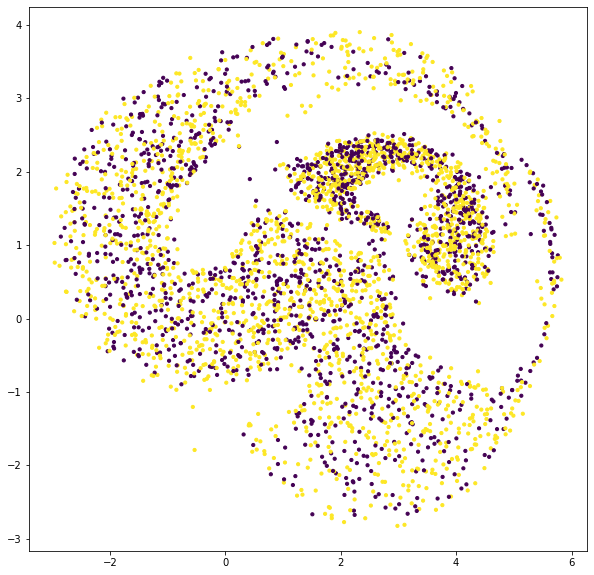

In [220]:
#UMAP visualization
embeds = UMAP(n_neighbors=150, min_dist=0.5, random_state=1).fit_transform(U)
plt.figure(figsize=(10,10))
plt.scatter(embeds[:,0], embeds[:,1], c=trainY, s=10)
plt.show()